# Project Multi Head Attention

Rules:
* You may use the libraries that are imported below (but don't have to use all of them).
* Don't use `torch.nn`, the rest of PyTorch is ok.

Submit this notebook in StudIP.

In [ ]:
import numpy as np
import scipy as sp
import math
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import fastprogress
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import random
import pandas as pd
#torch.nn = None  # torch.nn is not allowed

data = torch.load('exercise1_data.pth', weights_only=True, map_location=torch.device('cpu'))

print(data.keys())

dict_keys(['rope_qkv', 'mha_weights', 'some_tokens', 'cifar_tokens_test', 'cifar_tokens', 'cifar_labels'])


### Task 1: Simple Attention

Implement (single-head) scaled dot-product attention without projection layers, i.e. treat `x` as if it was queue, key and value.

In [ ]:
x = data['some_tokens'].clone()

def signle_head_attention(q, k, v):
    d = q.shape[0]
    return torch.softmax(q @ k.T / math.sqrt(d), dim=1) @ v

attention = signle_head_attention(x, x, x)
print(x.shape, attention.shape)

torch.Size([16, 100]) torch.Size([16, 100])


### Task 2: Multi-head Self-Attention

Implement multi-head scaled dot-product attention with 4 heads for 32-dimensional tokens `x`. Use `W_` as the weights for query, key and value, their first dimension corresponds to the number of heads.
Visualize the attention of each head.


In [ ]:
W_q, W_k, W_v = data['mha_weights']
W_q, W_k, W_v = W_q[0], W_k[0], W_v[0]
W_q.shape, W_k.shape, W_v.shape

(torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]))

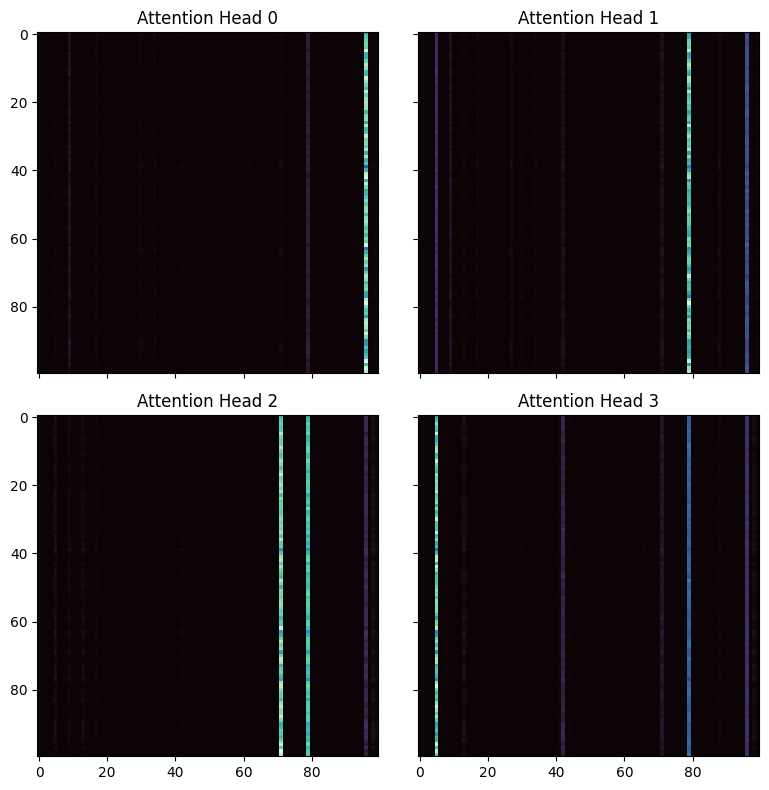

In [ ]:
def multi_head_attention(W_q, W_k, W_v, t, n_heads, verbose=False):
    batch_size, seq_len, embedding_dim = t.size()
    head_dim = embedding_dim // n_heads

    # Caclulate keys quieries and values from Weights
    q = torch.matmul(t, W_q.T)
    k = torch.matmul(t, W_k.T)
    v = torch.matmul(t, W_v.T)

    # Reshape and permute for multi-head attention
    q = q.view(batch_size, seq_len, n_heads, head_dim).transpose(1,2)
    k = k.view(batch_size, seq_len, n_heads, head_dim).transpose(1,2)
    v = v.view(batch_size, seq_len, n_heads, head_dim).transpose(1,2)

    # Compute attention scores
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dim)
    attn = torch.softmax(attn_scores, dim=-1)

    # Apply attention weights
    x = torch.matmul(attn, v)

    # Concatenate heads
    x = x.transpose(1,2).contiguous().view(batch_size, seq_len, embedding_dim)
    return x, attn


# Extract tokens
x = data['some_tokens'].clone()
x = x.T
x = x.unsqueeze(0)  # Shape: [1, seq_len, embedding_dim]

# Call multi_head_attention
x_out, att = multi_head_attention(W_q, W_k, W_v, x, 4, verbose=True)

# Remove batch dimension from attention weights
att = att.squeeze(0)  # Shape: [n_heads, seq_len, seq_len]

# Visualization function
def visualize(att):
    n_heads = att.shape[0]
    x_len = int(np.floor(np.sqrt(n_heads)))
    y_len = int(np.ceil(n_heads / x_len))
    fig, axes = plt.subplots(x_len, y_len, figsize=(8, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    for i in range(n_heads):
        im = axes[i].imshow(att[i].detach().cpu().numpy(), cmap='mako')
        axes[i].set_title(f'Attention Head {i}')
    plt.tight_layout()
    plt.show()

# Visualize attention
visualize(att)


### Task 3: RoPE Position Embedding

Implement RoPE positional embeddings and apply them on the tokens `x`. Note, the rotations are carried out in groups of two dimensions and each group has a different rotation rate.

In [ ]:
x = data['some_tokens'].clone()
x = x.unsqueeze(0)

print(x.shape)


def rope(x):
    batch_size, seq_len, embedding_dim = x.shape
    assert embedding_dim % 2 == 0, "Embedding dimension must be even."
    half_d = embedding_dim // 2

    device = x.device
    dtype = x.dtype

    # Calculate m and j arrays
    m = torch.arange(seq_len, device=device, dtype=dtype)
    j = torch.arange(half_d, device=device, dtype=dtype)

    # Calculate angles
    angles = m.unsqueeze(1) / (10000 ** (2 * j / embedding_dim))

    # Calculate sin and cos
    cos_angles = torch.cos(angles)
    sin_angles = torch.sin(angles)

    # Apply rotations
    x_even = x[:, :, 0::2]
    x_odd = x[:, :, 1::2]

    x_rotated_even = x_even * cos_angles - x_odd * sin_angles
    x_rotated_odd = x_even * sin_angles + x_odd * cos_angles

    x_rotated = torch.zeros_like(x)
    x_rotated[:, :, 0::2] = x_rotated_even
    x_rotated[:, :, 1::2] = x_rotated_odd

    return x_rotated

rope(x)

torch.Size([1, 16, 100])


tensor([[[ 0.6027,  0.8112,  0.0718,  ...,  0.6160,  0.9860,  0.8504],
         [-0.6333,  0.8522, -0.3951,  ...,  0.5147,  0.9438,  0.6180],
         [-0.1766,  0.0994, -0.4271,  ...,  0.1722,  0.5387,  0.8908],
         ...,
         [ 0.3729,  0.5675,  0.4338,  ...,  0.0709,  0.5259,  0.6727],
         [-0.7664,  0.6511,  0.0312,  ...,  0.4044,  0.6335,  0.7344],
         [-0.5429,  0.3121,  0.8599,  ...,  0.1379,  0.6128,  0.9205]]])

### Task 4: Transformer Architecture

- **Task 4.1**: Implement the layer norm function.
- **Task 4.2**: Implement a 2-layer MLP with ReLU non-linearity.
- **Task 4.3**: Compose this into a Transformer Layer. You can (but don't have to) use the code below. Note, since `torch.nn` is not available, we have to manage parameters manually.


In [ ]:
def xavier_uniform(tensor, gain=1.0):
    if tensor is not None:
        fan_in, fan_out = tensor.size(1), tensor.size(0)
        std = gain * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        with torch.no_grad():
            tensor.uniform_(-a, a)

def zeros(tensor):
    if tensor is not None:
        with torch.no_grad():
            tensor.zero_()


class TransformerEncoderLayer:
    def __init__(self, embedding_dim=48, hidden_dim=64, n_heads=4, mlp_layers=2, device='cpu'):
        self.device = device
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = embedding_dim // n_heads
        self.mlp_layers = mlp_layers

        # Attention weights
        self.att_W_q = torch.empty(embedding_dim, embedding_dim, device=self.device, requires_grad=True)
        self.att_W_k = torch.empty(embedding_dim, embedding_dim, device=self.device, requires_grad=True)
        self.att_W_v = torch.empty(embedding_dim, embedding_dim, device=self.device, requires_grad=True)

        # MLP weights and biases
        self.MLP_weights = []
        self.MLP_biases = []

        # Input dimension for the first MLP layer
        in_dim = embedding_dim

        for i in range(mlp_layers):
            # Determine output dimension
            out_dim = self.hidden_dim if i < mlp_layers - 1 else embedding_dim  # Last layer maps back to embedding_dim

            # Initialize weights and biases
            weight = torch.empty(out_dim, in_dim, device=self.device, requires_grad=True)
            bias = torch.empty(out_dim, device=self.device, requires_grad=True)

            # Apply custom Xavier Initialization to weights
            xavier_uniform(weight)
            # Initialize biases to zeros
            zeros(bias)

            # Append to lists
            self.MLP_weights.append(weight)
            self.MLP_biases.append(bias)

            # Update input dimension for next layer
            in_dim = out_dim

        # Apply custom Xavier Initialization to attention weights
        xavier_uniform(self.att_W_q)
        xavier_uniform(self.att_W_k)
        xavier_uniform(self.att_W_v)

    def layer_norm(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, unbiased=False, keepdim=True)
        return (x - mean) / (std + 1e-6)

    def forward(self, x):
        # x shape: [batch_size, seq_len, embedding_dim]
        x = rope(x)
        h, _ = multi_head_attention(self.att_W_q, self.att_W_k, self.att_W_v, x, self.n_heads)
        x = self.layer_norm(x + h)

        h = x
        for weight, bias in zip(self.MLP_weights, self.MLP_biases):
            h = torch.matmul(h, weight.T) + bias  # Shape: [batch_size, seq_len, out_dim]
            h = torch.relu(h)
        x = self.layer_norm(x + h)
        return x

    def get_parameters(self):
        params = [self.att_W_q, self.att_W_k, self.att_W_v]
        params.extend(self.MLP_weights)
        params.extend(self.MLP_biases)
        return params


embedding_dim = x.shape[1]  # Get embedding_dim from x
hidden_dim = 64  # You can adjust this as needed
n_heads = 4

layer1 = TransformerEncoderLayer(embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_heads=n_heads)
layer2 = TransformerEncoderLayer(embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_heads=n_heads)

def forward(x):
    x = layer1.forward(x)
    x = layer2.forward(x)
    return x


x = data['some_tokens'].clone()
x = x.T
x = x.unsqueeze(0)
x = forward(x)

### Task 5: CIFAR Training

Use your network and train it on CIFAR-100. Use the cross-entropy loss function.
Use your own train/val split.

In [ ]:
cifar_tokens, cifar_labels = data['cifar_tokens'], data['cifar_labels']

In [ ]:
cifar_tokens.shape # 10000 samples, each is a 8 x 8 grid of 48-dimensional tokens.



torch.Size([10000, 8, 8, 48])

In [ ]:
# Train and validation split are done here

def train_test_split(x, y, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(x))
    test_size = int(len(x) * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    x_train, x_test = x[train_indices], x[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return x_train, x_test, y_train, y_test


In [ ]:
#For classification we need a Multilayer perceptron at the end of our Transformer Layers

class MLPHead:
    def __init__(self, embedding_dim=48, token_nr=64, hidden_units=512, hidden_layers=1, num_classes=100, device='cpu'):
        self.device = device
        self.embedding_dim = embedding_dim
        self.token_nr = token_nr
        self.hidden_units = hidden_units
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes

        # Initialize parameters
        self.parameters = []

        # Input layer weights and bias
        input_weight = torch.empty(hidden_units, embedding_dim * token_nr, device=self.device, requires_grad=True)
        input_bias = torch.empty(hidden_units, device=self.device, requires_grad=True)
        xavier_uniform(input_weight)
        zeros(input_bias)
        self.parameters.extend([input_weight, input_bias])

        # Hidden layers weights and biases
        for _ in range(hidden_layers):
            hidden_weight = torch.empty(hidden_units, hidden_units, device=self.device, requires_grad=True)
            hidden_bias = torch.empty(hidden_units, device=self.device, requires_grad=True)
            xavier_uniform(hidden_weight)
            zeros(hidden_bias)
            self.parameters.extend([hidden_weight, hidden_bias])

        # Output layer weights and bias
        output_weight = torch.empty(num_classes, hidden_units, device=self.device, requires_grad=True)
        output_bias = torch.empty(num_classes, device=self.device, requires_grad=True)
        xavier_uniform(output_weight)
        zeros(output_bias)
        self.parameters.extend([output_weight, output_bias])

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)

        for i in range(0, len(self.parameters) - 2, 2):
            weight = self.parameters[i]
            bias = self.parameters[i + 1]
            x = torch.matmul(x, weight.T) + bias
            x = torch.relu(x)

        weight = self.parameters[-2]
        bias = self.parameters[-1]
        x = torch.matmul(x, weight.T) + bias
        return x

    def get_parameters(self):
        return self.parameters

In [ ]:
def cross_entropy_loss(logits, targets):
    log_probs = torch.log_softmax(logits, dim=1)
    targets_log_probs = log_probs[torch.arange(logits.size(0)), targets]
    loss = -targets_log_probs.mean()
    return loss

def get_optimizer(optimizer_type, parameters, **kwargs):
    if optimizer_type == "SGD":
        return torch.optim.SGD(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            momentum=kwargs.get("momentum", 0.9),
            weight_decay=kwargs.get("weight_decay", 0.0),
            nesterov=kwargs.get("nesterov", False)
        )
    elif optimizer_type == "Adam":
        return torch.optim.Adam(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            betas=kwargs.get("betas", (0.9, 0.999)),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0)
        )
    elif optimizer_type == "AdamW":
        return torch.optim.AdamW(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            betas=kwargs.get("betas", (0.9, 0.999)),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0)
        )
    elif optimizer_type == "RMSprop":
        return torch.optim.RMSprop(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            alpha=kwargs.get("alpha", 0.99),
            momentum=kwargs.get("momentum", 0.0),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0)
        )
    elif optimizer_type == "Adagrad":
        return torch.optim.Adagrad(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            lr_decay=kwargs.get("lr_decay", 0.0),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0)
        )
    elif optimizer_type == "Adadelta":
        return torch.optim.Adadelta(
            parameters,
            lr=kwargs.get("lr", 1e-4),
            rho=kwargs.get("rho", 0.9),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0)
        )
    else:
        raise ValueError(f"Invalid optimizer type: {optimizer_type}")


def train(
    tokens,
    labels,
    epochs,
    nr_tran_layers,
    nr_hidden_units_head,
    nr_hidden_layers_head,
    batch_size=32,
    hidden_dim=64,
    n_heads=4,
    mlp_layers_tran_enc=2,
    token_nr=None,
    num_classes=100,
    patience=5,
    optimizer_config=None,
    noise_factor=0.0
):


    # Determine embedding_dim from tokens
    embedding_dim = tokens.shape[-1]

    from sklearn.metrics import confusion_matrix
    from fastprogress import master_bar, progress_bar
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    tokens = tokens.float() / 255.0
    labels = labels.long()
    tokens = tokens.reshape(tokens.shape[0], -1, tokens.shape[-1])

    # Determine token_nr if not provided
    if token_nr is None:
        token_nr = tokens.shape[1]  # Assuming tokens shape is [batch_size, seq_len, embedding_dim]

    x_train, x_test, y_train, y_test = train_test_split(tokens, labels, test_ratio=0.2)

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define model layers with adjustable hyperparameters
    layers = [
        TransformerEncoderLayer(
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            n_heads=n_heads,
            mlp_layers=mlp_layers_tran_enc,
            device=device
        )
        for _ in range(nr_tran_layers)
    ]
    layers.append(
        MLPHead(
            embedding_dim=embedding_dim,
            token_nr=token_nr,
            hidden_units=nr_hidden_units_head,
            hidden_layers=nr_hidden_layers_head,
            num_classes=num_classes,
            device=device
        )
    )

    # Define forward pass
    def forward(x):
        for layer in layers:
            x = layer.forward(x)
        return x

    parameters = [layer.get_parameters() for layer in layers]
    parameters = [param for sublist in parameters for param in sublist]

    for param in parameters:
        assert param.is_leaf, "Parameter is not a leaf tensor"

    if optimizer_config is None:
        optimizer_config = {
            "type": "Adam",
            "lr": 1e-4
        }
    optim = get_optimizer(optimizer_config['type'], parameters, **optimizer_config)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_accuracy = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    best_model_params = [param.clone().detach() for param in parameters]

    mb = master_bar(range(epochs))
    for i_epoch in mb:
        # Training
        running_loss = 0.0
        correct = 0
        total = 0
        pb = progress_bar(train_loader, parent=mb)
        for x_batch, y_batch in pb:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Add random noise to x_batch
            if noise_factor > 0.0:
                noise = noise_factor * torch.randn_like(x_batch)
                x_batch_noisy = x_batch + noise
            else:
                x_batch_noisy = x_batch

            optim.zero_grad()
            y_pred = forward(x_batch_noisy)
            loss = cross_entropy_loss(y_pred, y_batch)
            loss.backward()
            optim.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        avg_train_loss = running_loss / total
        train_losses.append(avg_train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation
        running_val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = forward(x_batch)
                loss = cross_entropy_loss(y_pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())

        avg_val_loss = running_val_loss / total
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Update master bar
        mb.main_bar.comment = f'Epoch {i_epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}'

        # Early Stopping Check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = i_epoch
            epochs_no_improve = 0
            # Save the best model parameters
            best_model_params = [param.clone().detach() for param in parameters]
        else:
            epochs_no_improve += 1

        # Stop training if validation accuracy hasn't improved for 'patience' epochs
        if epochs_no_improve >= patience:

            mb.write(f"Early stopping triggered after {i_epoch+1} epochs.")
            break


    # Load best model parameters
    for param, best_param in zip(parameters, best_model_params):
        param.data = best_param.data.clone()

    # Compute confusion matrix on the test set
    confusion_mat = confusion_matrix(all_targets, all_preds)

    mb.write(f"Best Epoch: {best_epoch+1}, Best Validation Accuracy: {best_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, layers, confusion_mat




In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', marker='o', label='Training Loss')
    plt.plot(epochs, val_losses, 'b-', marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', marker='o', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b-', marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(confusion_matrix):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()





In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies, layers, confusion_matrix = train(
    cifar_tokens,
    cifar_labels,
    epochs=100,
    nr_tran_layers=1,
    nr_hidden_units_head=1024,
    nr_hidden_layers_head=2,
    batch_size=16
)


Using device: cuda


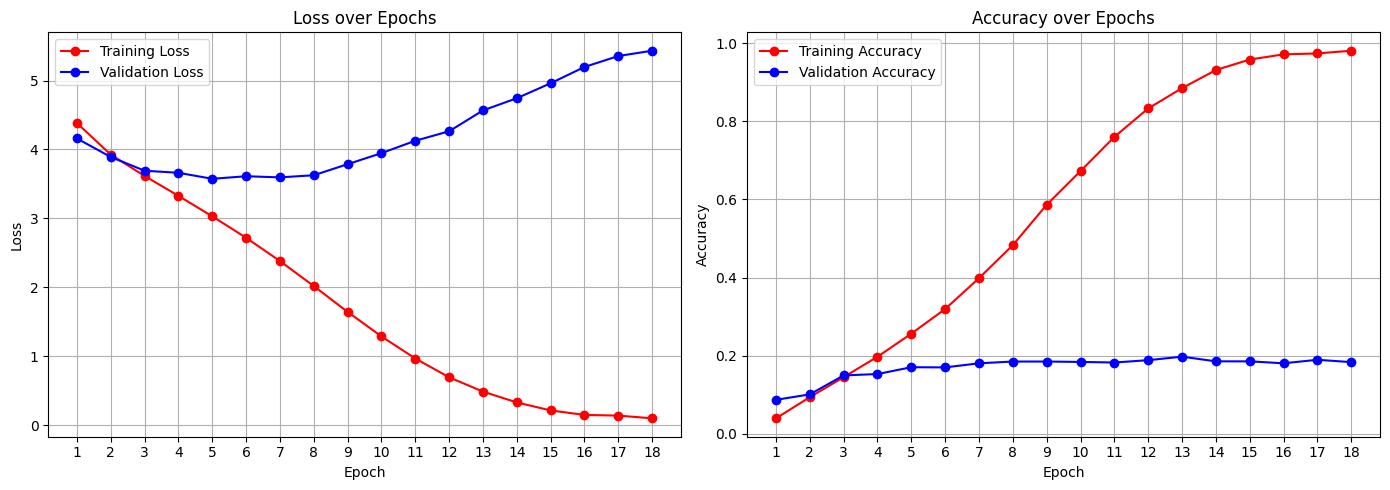

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


We can see that the model traines but massivly overfits. We get a validation accuracy of around 20%

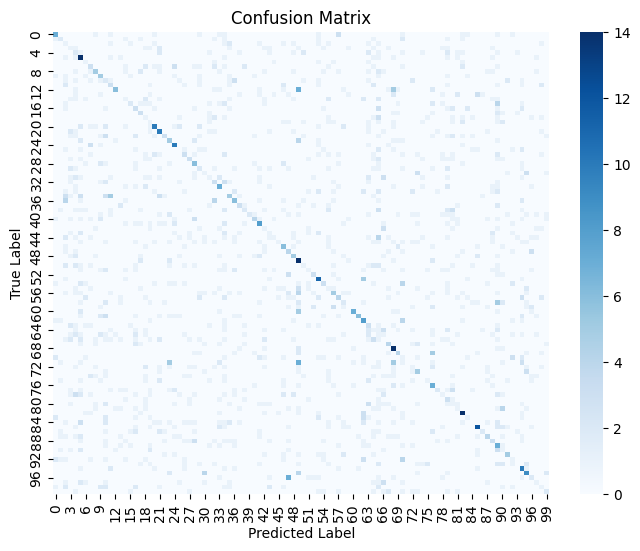

In [ ]:
plot_confusion_matrix(confusion_matrix)

In [ ]:
"""train_losses, val_losses, train_accuracies, val_accuracies, layers, confusion_matrix = train(
    cifar_tokens, cifar_labels, epochs=100, lr=1e-4, nr_tran_layers=1,
    nr_hidden_units_head=1024, nr_hidden_layers_head=2, batch_size=16
)"""

from IPython.display import clear_output



def random_search(tokens, labels, n_experiments=10):
    # Get embedding_dim from tokens
    embedding_dim = tokens.shape[-1]

    # Lists to store results
    results = []

    for i in range(n_experiments):
        clear_output(wait=True)
        print(f"Experiment {i+1}/{n_experiments}")
        #Try to find the all time best validation accuracy and print it
        try:
          accuracies = [i['best_val_accuracy'] for i in results]
          print(f"Best validation accuracy: {max(accuracies)}")
        except:
          print("No results yet")
        # Randomly sample hyperparameters
        lr = 10 ** random.uniform(-5, -3)  # Log-uniform between 1e-5 and 1e-2
        nr_tran_layers = random.randint(1, 4)
        nr_hidden_units_head = random.choice([128, 256, 512, 1024, 2048, 3072])
        nr_hidden_layers_head = random.randint(1, 4)
        # Remove embedding_dim from random selection
        # embedding_dim = tokens.shape[-1]  # Set embedding_dim to match tokens
        hidden_dim = random.choice([64, 128, 256, 512, 1024, 3072])
        mlp_layers_tran_enc = random.randint(1, 4)
        batch_size = random.choice([16, 32, 64, 128, 256])
        n_heads_choices = [n for n in range(1, embedding_dim + 1) if embedding_dim % n == 0 and n <= 8]
        n_heads = random.choice(n_heads_choices)
        noise_factor = random.choice([0.0, random.uniform(0.0, 0.02)])
        # Randomly select an optimizer
        optimizer_type = random.choice(["SGD", "Adam", "AdamW", "RMSprop", "Adagrad", "Adadelta"])

        optimizer_config = {
            "type": optimizer_type,
            "lr": lr
        }

        if optimizer_type == "SGD":
            optimizer_config.update({
                "momentum": random.uniform(0.8, 0.99),
                "weight_decay": 10 ** random.uniform(-6, -3),
                "nesterov": random.choice([True, False])
            })
        elif optimizer_type in ["Adam", "AdamW"]:
            optimizer_config.update({
                "betas": (random.uniform(0.8, 0.99), random.uniform(0.95, 0.999)),
                "eps": 10 ** random.uniform(-8, -6),
                "weight_decay": 10 ** random.uniform(-6, -3)
            })
        elif optimizer_type == "RMSprop":
            optimizer_config.update({
                "alpha": random.uniform(0.8, 0.99),
                "momentum": random.uniform(0.0, 0.9),
                "eps": 10 ** random.uniform(-8, -6),
                "weight_decay": 10 ** random.uniform(-6, -3)
            })
        elif optimizer_type == "Adagrad":
            optimizer_config.update({
                "lr_decay": random.uniform(0.0, 0.1),
                "eps": 10 ** random.uniform(-8, -6),
                "weight_decay": 10 ** random.uniform(-6, -3)
            })
        elif optimizer_type == "Adadelta":
            optimizer_config.update({
                "rho": random.uniform(0.8, 0.99),
                "eps": 10 ** random.uniform(-8, -6),
                "weight_decay": 10 ** random.uniform(-6, -3)
            })



        # Ensure that embedding_dim is divisible by n_heads
        if not n_heads_choices:
            print(f"Skipping experiment {i+1} due to no valid n_heads for embedding_dim {embedding_dim}.")
            continue

        # Train the model
        try:
            train_losses, val_losses, train_accuracies, val_accuracies, layers, confusion_mat = train(
                tokens,
                labels,
                epochs=100,
                nr_tran_layers=nr_tran_layers,
                nr_hidden_units_head=nr_hidden_units_head,
                nr_hidden_layers_head=nr_hidden_layers_head,
                batch_size=batch_size,
                hidden_dim=hidden_dim,
                n_heads=n_heads,
                mlp_layers_tran_enc=mlp_layers_tran_enc,
                num_classes=100,
                patience=10,
                optimizer_config=optimizer_config,
                noise_factor = noise_factor
            )
        except Exception as e:
            print(f"An error occurred during training: {e}")
            continue

        # Collect the best validation accuracy and loss
        best_val_accuracy = max(val_accuracies)
        best_val_loss = min(val_losses)

        # Store the results
        result = {
            'lr': lr,
            'nr_tran_layers': nr_tran_layers,
            'nr_hidden_units_head': nr_hidden_units_head,
            'nr_hidden_layers_head': nr_hidden_layers_head,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'n_heads': n_heads,
            'mlp_layers_tran_enc': mlp_layers_tran_enc,
            'batch_size': batch_size,
            'noise_factor': noise_factor,
            'optimizer_type': optimizer_type,
            'optimizer_config': optimizer_config,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies' : val_accuracies,
            'best_val_accuracy': best_val_accuracy,
            'best_val_loss': best_val_loss,
            'confusion_matrix': confusion_mat,
            'layers': layers
        }
        results.append(result)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


def visualize_results(results_df):

  # List of hyperparameters
  hyperparams = [
      'lr',
      'nr_tran_layers',
      'nr_hidden_units_head',
      'nr_hidden_layers_head',
      'embedding_dim',
      'hidden_dim',
      'n_heads',
      'mlp_layers_tran_enc',
      'batch_size',
      'noise_factor',
      'train_losses',
      'optimizer_type',
      'optimizer_config',

  ]

  for param in hyperparams:
    try:
      plt.figure(figsize=(8, 6))
      sns.scatterplot(data=results_df, x=param, y='best_val_accuracy')
      plt.title(f'Validation Accuracy vs {param}')
      plt.ylabel('Validation Accuracy')
      plt.xlabel(param)
      plt.show()
    except Exception as e:
      print(f"An error occurred while plotting {param}: {e}")



In [ ]:
# Number of experiments to run
n_experiments = 5

cifar_tokens, cifar_labels = data['cifar_tokens'], data['cifar_labels']

cifar_tokens = cifar_tokens.float() / 255.0
training_mean = cifar_tokens.mean()
training_std = cifar_tokens.std()
cifar_tokens = (cifar_tokens - training_mean) / training_std


# Perform random hyperparameter search
results_df = random_search(cifar_tokens, cifar_labels, n_experiments=n_experiments)


Experiment 5/5
Best validation accuracy: 0.1815
Using device: cuda


In [ ]:
#Print the best architecture hyperparamters:

best_result = results_df.loc[results_df['best_val_accuracy'].idxmax()]

print(best_result)

lr                                                                0.000053
nr_tran_layers                                                           3
nr_hidden_units_head                                                  1024
nr_hidden_layers_head                                                    3
embedding_dim                                                           48
hidden_dim                                                            1024
n_heads                                                                  6
mlp_layers_tran_enc                                                      4
batch_size                                                             128
noise_factor                                                           0.0
optimizer_type                                                     RMSprop
optimizer_config         {'type': 'RMSprop', 'lr': 5.342011164715643e-0...
train_losses             [4.236371120452881, 3.708967992782593, 3.37471...
val_losses               

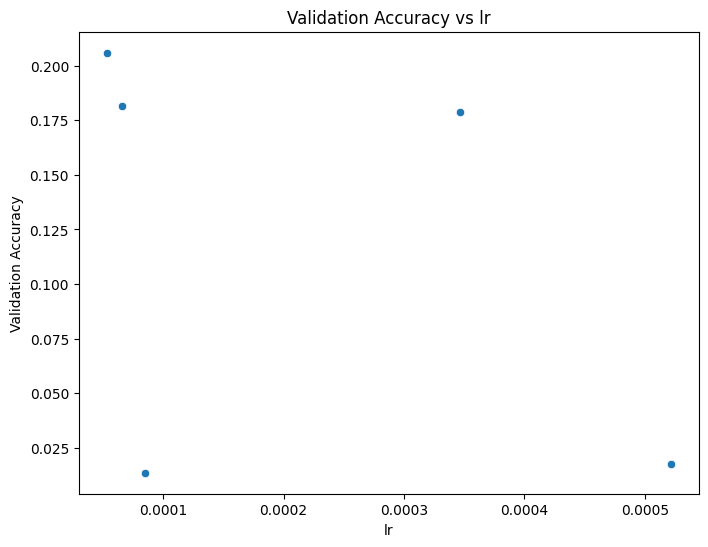

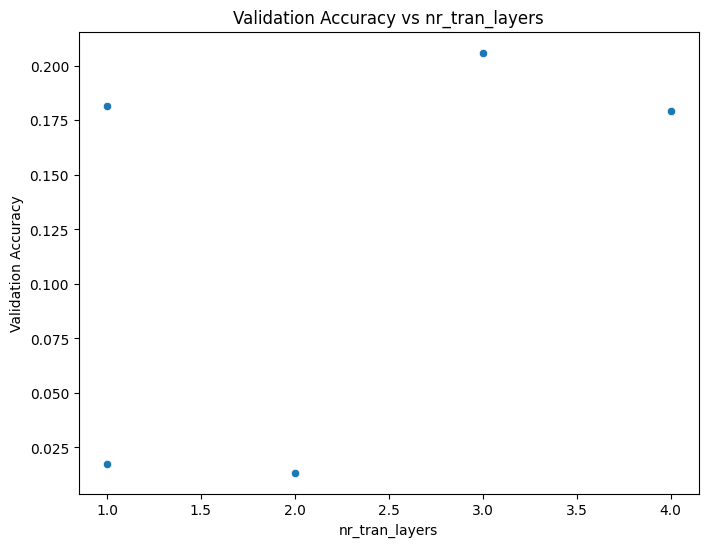

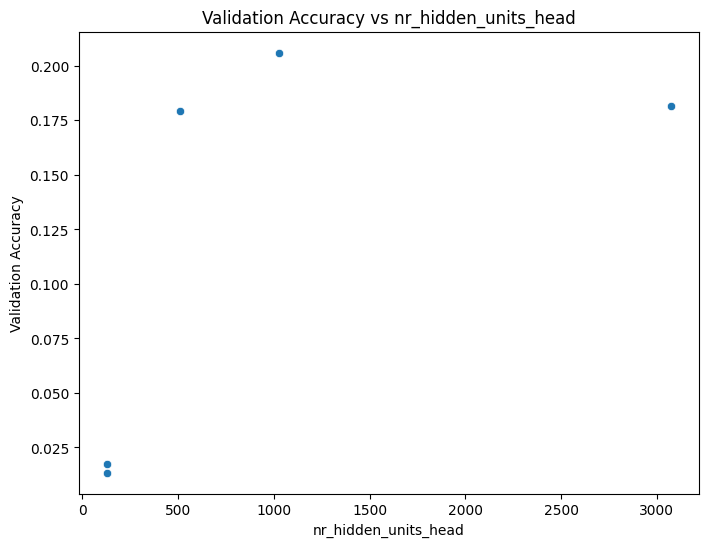

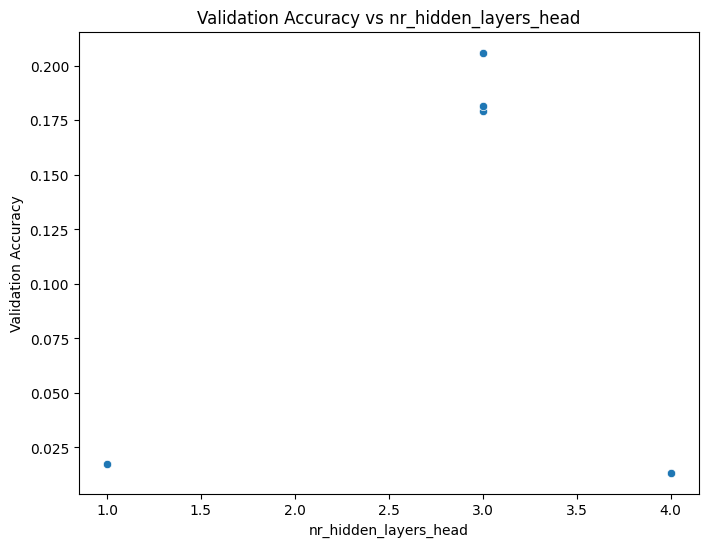

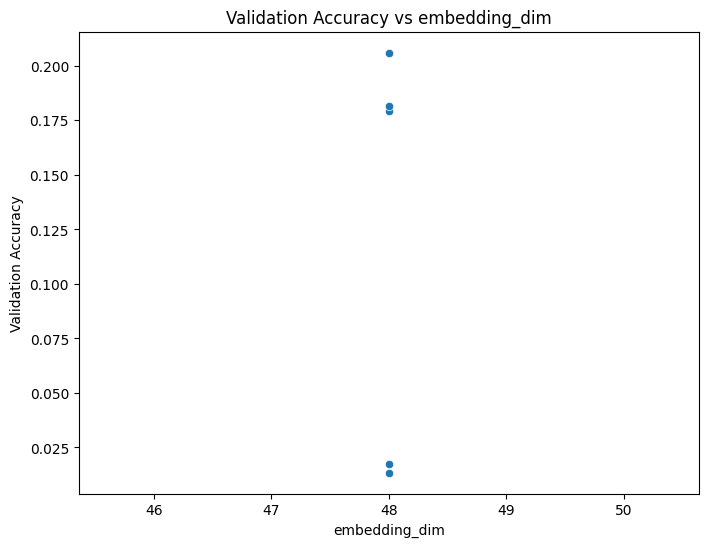

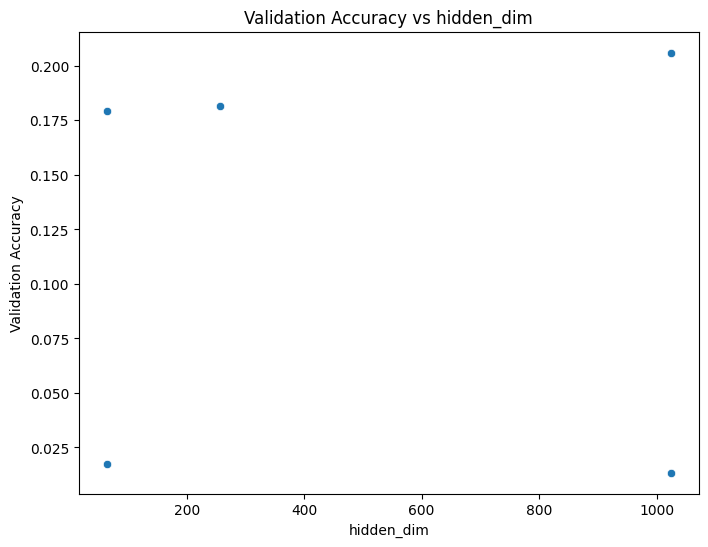

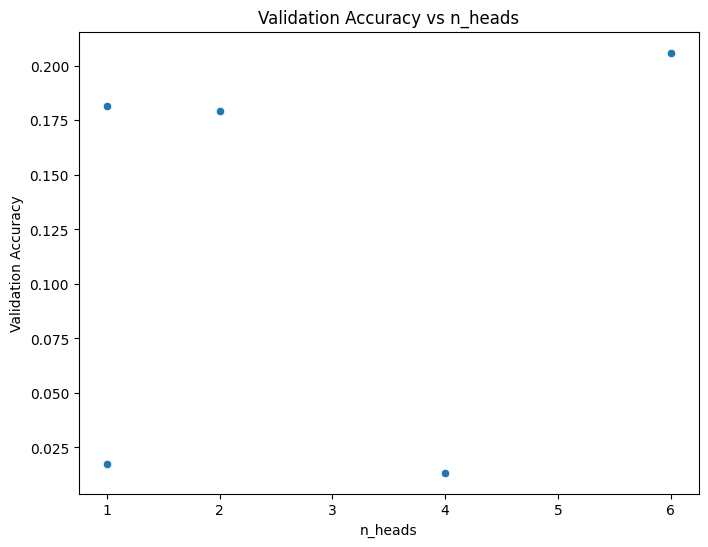

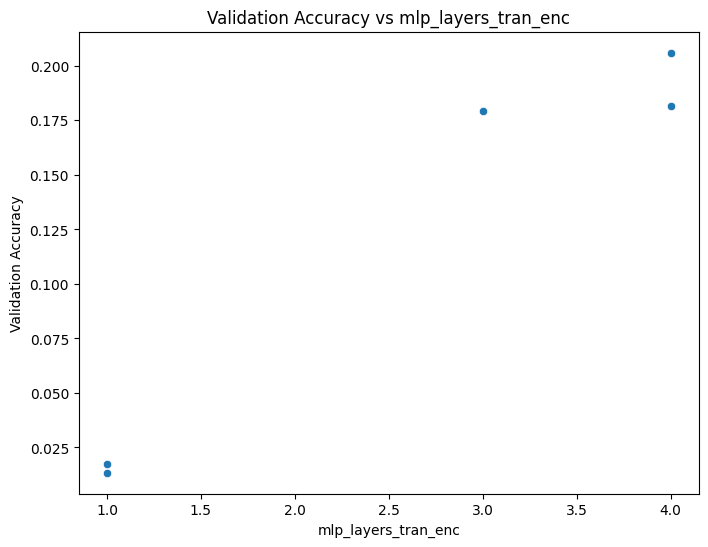

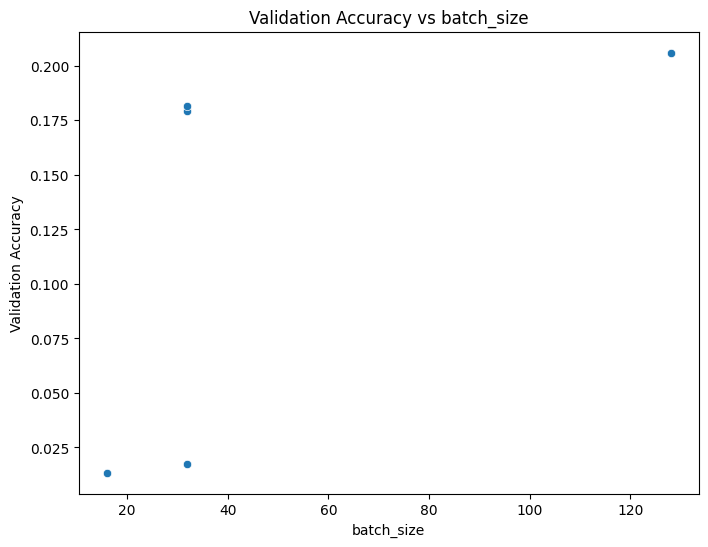

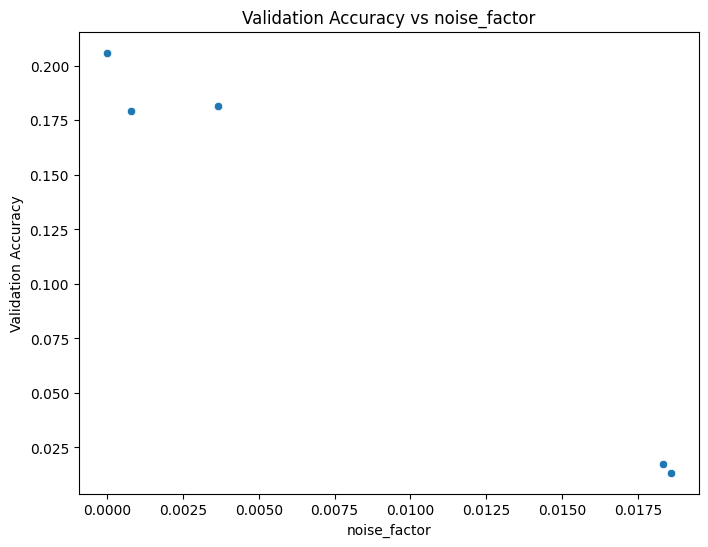

An error occurred while plotting train_losses: unhashable type: 'list'


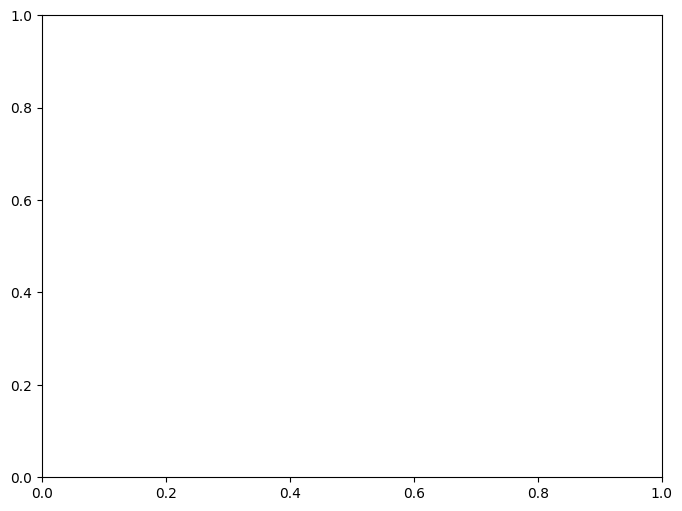

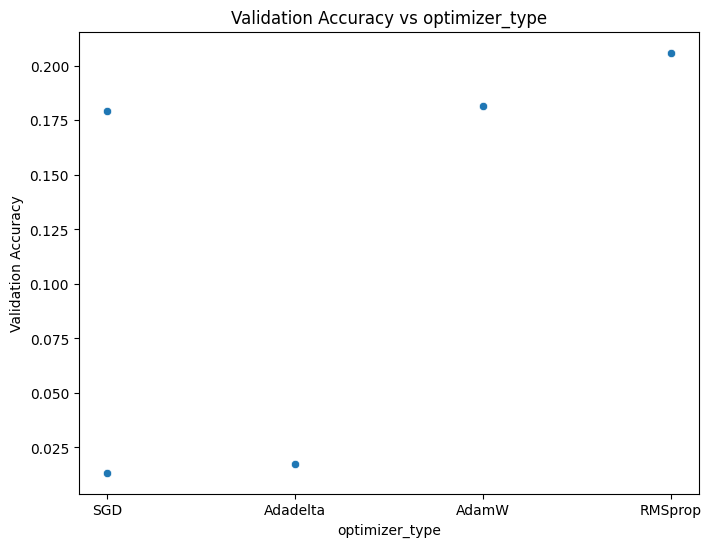

An error occurred while plotting optimizer_config: unhashable type: 'dict'


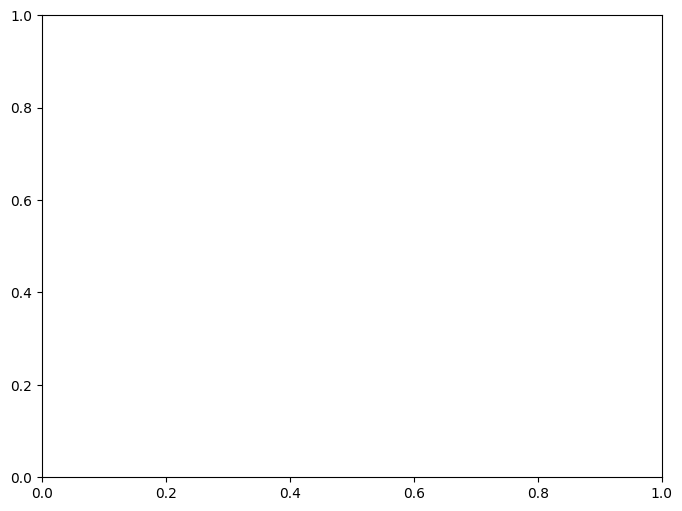

In [ ]:
# Visualize the results
visualize_results(results_df)


Updated data has been saved to 'exercise1_data_with_labels.pth'.

Keys in the updated data dictionary:
dict_keys(['cifar_labels_test'])

 Print Datatype of 'cifar_labels_test' and 'cifar_labels':
torch.int64

 Shape of the 'cifar_labels_test' and 'cifar_labels':
torch.Size([5000])

First 10 entries of 'cifar_labels_test' and 'cifar_labels':
tensor([48, 19, 95, 22, 47, 36, 75, 54, 63, 41, 23, 31, 35,  1, 14,  6,  4, 65,
        63, 35, 52, 59, 22, 35, 88, 85, 18, 70, 19,  4, 34, 82,  6, 17, 15, 68,
        73, 47, 53, 11, 74, 10, 80, 65, 19, 25, 28, 89, 39, 94, 48, 89, 17, 98,
        62, 49, 81, 16, 13, 85, 63,  1, 97, 33, 59, 74, 55, 95, 40,  2, 52, 13,
        93,  8, 98, 47, 78, 95, 86, 65, 38, 30, 75, 37, 80, 41, 27, 52, 56, 31,
        63,  8, 56,  7, 76, 47, 83, 38, 79, 21])


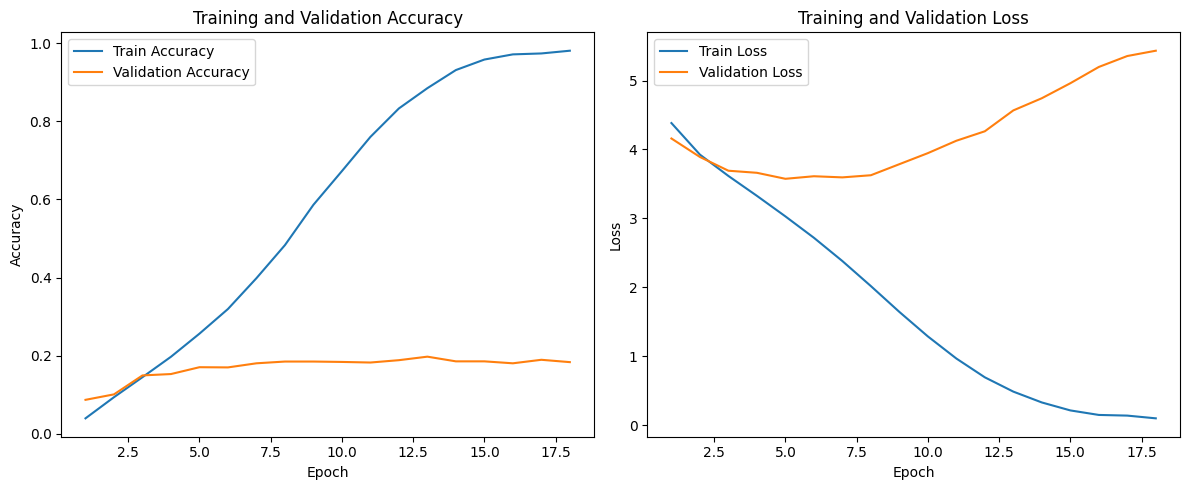

In [ ]:

# Prepare the test tokens
test_tokens = data['cifar_tokens_test']
test_tokens = test_tokens.float() / 255.0
# Standardize using training data statistics
test_tokens = (test_tokens - training_mean) / training_std
# Reshape to [num_samples, seq_len, embedding_dim]
test_tokens = test_tokens.reshape(test_tokens.shape[0], -1, test_tokens.shape[-1])

# Convert test_tokens to a TensorDataset
test_dataset = TensorDataset(test_tokens)

# Select the best result based on validation accuracy
best_result = results_df.loc[results_df['best_val_accuracy'].idxmax()]

# Ensure batch_size is a native Python integer
batch_size = int(best_result['batch_size'])

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Retrieve the best model layers
best_layers = best_result['layers']

try:
    first_param = next(iter(best_layers[0].get_parameters()))
    device = first_param.device
except StopIteration:
    device = torch.device('cpu')  # Fallback to CPU if no parameters found

# Define the forward pass using the best layers
def forward_best_model(x):
    for layer in best_layers:
        x = layer.forward(x)
    return x

# Generate predictions on the test set
all_preds = []

with torch.no_grad():
    for (x_batch,) in test_loader:
        # Move batch to the device
        x_batch = x_batch.to(device)
        # Forward pass
        y_pred = forward_best_model(x_batch)
        # Get predicted classes
        _, predicted = torch.max(y_pred.data, 1)
        # Collect predictions
        all_preds.extend(predicted.cpu().numpy())


output_data = dict()

output_data['cifar_labels_test'] = torch.tensor(all_preds, dtype=torch.long)

updated_file_path = 'exercise1_data_with_labels.pth'
torch.save(output_data, updated_file_path)

print(f"Updated data has been saved to '{updated_file_path}'.")


print("\nKeys in the updated data dictionary:")
print(output_data.keys())

print("\n Print Datatype of 'cifar_labels_test' and 'cifar_labels':")
print(output_data['cifar_labels_test'].dtype)

print("\n Shape of the 'cifar_labels_test' and 'cifar_labels':")
print(output_data['cifar_labels_test'].shape)

print("\nFirst 10 entries of 'cifar_labels_test' and 'cifar_labels':")
print(output_data['cifar_labels_test'][:100])


epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()




<ipython-input-23-a89fb5a9c095>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=pred_df, palette='viridis')


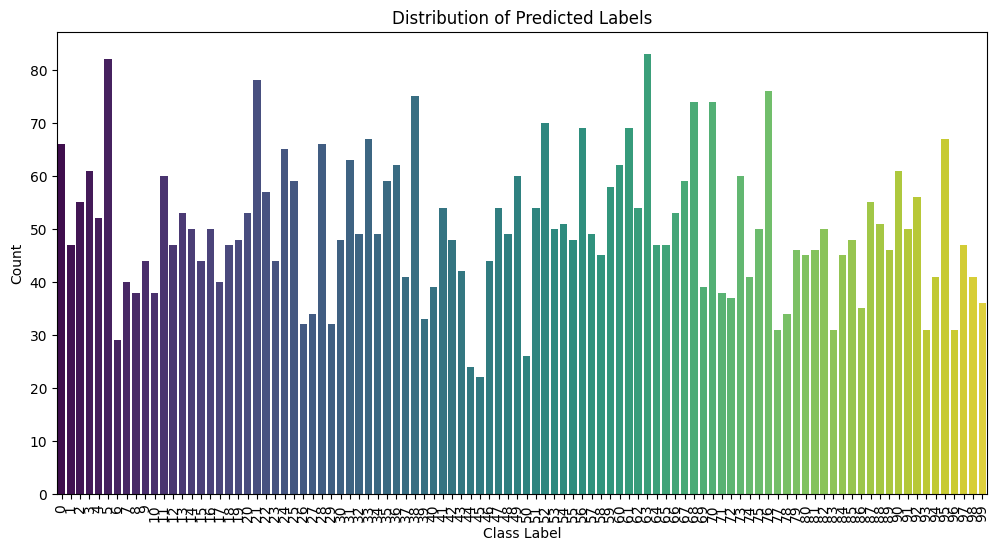

In [ ]:

# Convert 'all_preds' to a NumPy array if it's a list
predictions = np.array(all_preds)

# Create a DataFrame for easier plotting
pred_df = pd.DataFrame({'predicted_label': predictions})

plt.figure(figsize=(12, 6))
sns.countplot(x='predicted_label', data=pred_df, palette='viridis')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()